In [1]:
# 1. Use CNN instead of FC
# 2. Support GPU mode
# 3. Overfitting improved by dropout (only during training)

import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
training_dataset

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)
print('train length: ', len(training_loader), 'val length', len(validation_loader))


train length:  600 val length 100


In [21]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0) # move channels: Color x w x h -> w x h x color
    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


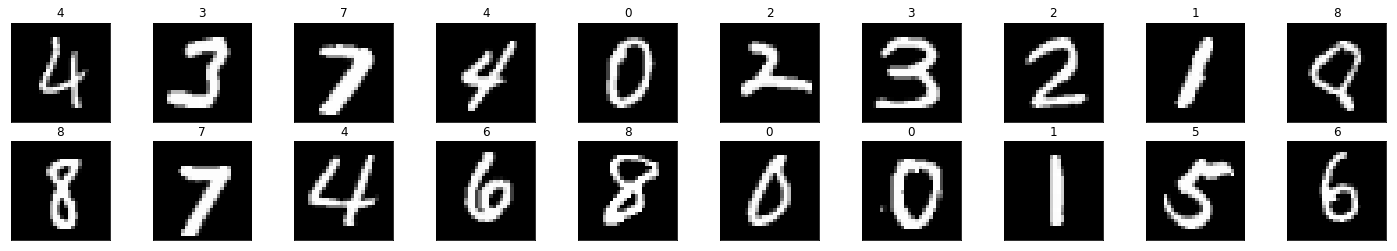

In [4]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

In [25]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        # self.conv1 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # cut by half
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2) # cut by half
        x = x.view(-1, 4*4*50) # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [26]:
model = LeNet().to(device)
model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [27]:
epochs = 12
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # inputs = inputs.view(inputs.shape[0], -1) #1, 28, 28 -> flatten: 1, 784
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss= criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('epoch: ', e+1)
        print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('validation loss: {:.4f}, validation acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc))
    

epoch:  1
training loss: 0.5817, acc: 84.4533
validation loss: 0.1876, validation acc: 94.5000
epoch:  2
training loss: 0.1502, acc: 95.5850
validation loss: 0.1035, validation acc: 96.8500
epoch:  3
training loss: 0.1008, acc: 96.9633
validation loss: 0.0760, validation acc: 97.7100
epoch:  4
training loss: 0.0775, acc: 97.6317
validation loss: 0.0690, validation acc: 97.8300
epoch:  5
training loss: 0.0634, acc: 98.0683
validation loss: 0.0514, validation acc: 98.5000
epoch:  6
training loss: 0.0561, acc: 98.3150
validation loss: 0.0462, validation acc: 98.5900
epoch:  7
training loss: 0.0496, acc: 98.4300
validation loss: 0.0438, validation acc: 98.5200
epoch:  8
training loss: 0.0439, acc: 98.6533
validation loss: 0.0422, validation acc: 98.7100
epoch:  9
training loss: 0.0401, acc: 98.8083
validation loss: 0.0386, validation acc: 98.6900
epoch:  10
training loss: 0.0358, acc: 98.8750
validation loss: 0.0342, validation acc: 98.7900
epoch:  11
training loss: 0.0332, acc: 99.0267
va

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


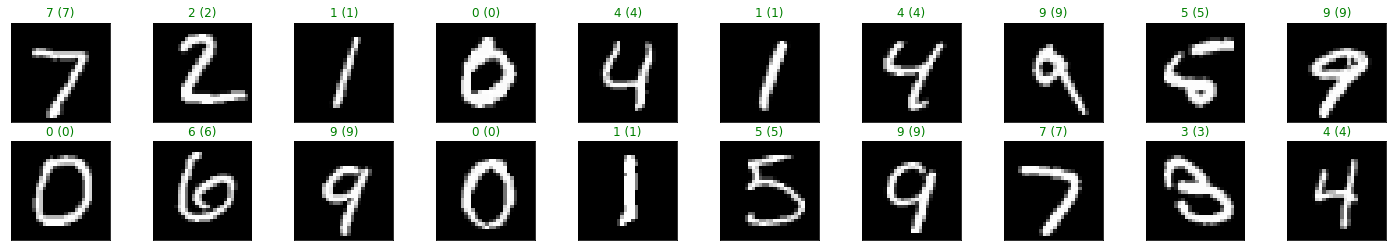

In [28]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# images_ = images.view(images.shape[0],-1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format( preds[idx].item(), labels[idx].item()), 
                 color = ('green' if preds[idx] == labels[idx] else 'red')  )

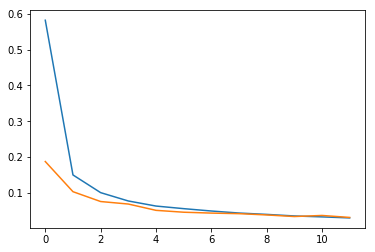

In [29]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')

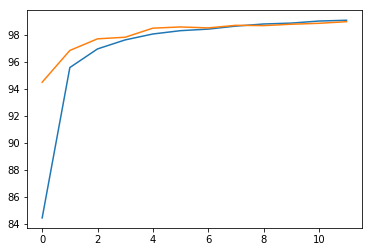

In [30]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')